# BLOCK-T227 Dynamic Tests Analysis

In [1]:
block_id = "BLOCK-T227"
day_obs = 20241026

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from astropy.time import Time
from astropy import units as u
from datetime import datetime

from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import getDayObsStartTime, makeEfdClient
from lsst.summit.utils.tmaUtils import TMAEvent, TMAEventMaker, TMAState

import BLOCK_T227_utils as block

# Create a client to access the Engineering Facility Database
efd_client = makeEfdClient()

# Create an object that mines TMA Slew Events
event_maker = TMAEventMaker()

In [3]:
day_obs = int(day_obs)
start_time = getDayObsStartTime(day_obs)
end_time = start_time + 1 * u.day

print(
    f"\nQuery data for {day_obs}"
    f"\n  starts at {start_time.isot} and"
    f"\n  ends at {end_time.isot}\n"
)


Query data for 20241026
  starts at 2024-10-26T12:00:00.000 and
  ends at 2024-10-27T12:00:00.000



## Querying data

Here I am trying to query the data based on information stored in the EFD. I am assuming that I do not have any information other than the test case id and the execution date. 

In [4]:
# Query blocks status
df_block_status = block.query_block_status(efd_client, start_time, end_time, block_id)

# Select relevant columns
df_block_status = df_block_status[["id", "status"]]

In [5]:
df_block_status

,id,status
2024-10-27 07:06:37.934694+00:00,BLOCK-T227,STARTED
2024-10-27 07:16:07.463834+00:00,BLOCK-T227,STARTED
2024-10-27 07:48:42.601261+00:00,BLOCK-T227,STARTED
2024-10-27 07:51:08.578495+00:00,BLOCK-T227,STARTED
2024-10-27 08:28:22.354645+00:00,BLOCK-T227,STARTED
2024-10-27 08:55:48.736711+00:00,BLOCK-T227,EXECUTING


The DataFrame above shows me that the BLOCK started five times. However, there not much more information in it. I ommitted several columns that did not seem useful for this analysis. 

In [6]:
# Query script status 
df_script_status = block.query_script_states(efd_client, start_time, end_time, block_id)

# Select most relevant columns
df_script_status = df_script_status[["blockId", "lastCheckpoint", "salIndex", "state"]]

# Convert `state`, which is an int, into a string from readability
df_script_status["state_name"] = df_script_status["state"].apply(block.convert_script_state)

# For each `blockId`, drop duplicates to it is easier to read
df_script_status = df_script_status.drop_duplicates(subset=["blockId", "state_name"])

In [7]:
df_script_status

,blockId,lastCheckpoint,salIndex,state,state_name
2024-10-27 07:06:47.111542+00:00,BT227_O_20241026_000001,,100271,2,CONFIGURED
2024-10-27 07:06:48.237087+00:00,BT227_O_20241026_000001,,100270,3,RUNNING
2024-10-27 07:06:55.359559+00:00,BT227_O_20241026_000001,None: azel grid 153.0/34.0 1/1,100270,7,FAILING
2024-10-27 07:07:01.564360+00:00,BT227_O_20241026_000001,None: azel grid 153.0/34.0 1/1,100270,10,FAILED
2024-10-27 07:16:16.510233+00:00,BT227_O_20241026_000002,,100283,2,CONFIGURED
2024-10-27 07:16:17.552888+00:00,BT227_O_20241026_000002,,100282,3,RUNNING
2024-10-27 07:18:24.598046+00:00,BT227_O_20241026_000002,None: azel grid 153.0/34.0 1/1,100282,7,FAILING
2024-10-27 07:18:29.516836+00:00,BT227_O_20241026_000002,None: azel grid 153.0/34.0 1/1,100282,10,FAILED
2024-10-27 07:48:52.082979+00:00,BT227_O_20241026_000003,,100297,2,CONFIGURED
2024-10-27 07:48:52.867050+00:00,BT227_O_20241026_000003,,100296,3,RUNNING


Here I am getting more information. With the DataFrame above I can confirm that the block failed four times before it passed. I can use the table above to investigate with more details why the block execution failed. This is out of the scope of this notebook. However, here are a few queries that we could try if we wanted to investigate more. 

In [8]:
# Query Scripts description
df_script_description = block.query_script_description(efd_client, start_time, end_time, block_id)

# Filter most useful columns
df_script_description = df_script_description[["classname", "description", "salIndex"]]

In [9]:
df_script_description.head()

,classname,description,salIndex
2024-10-26 15:34:51.197572+00:00,MTSchedulerAddBlock,Load block to the MAIN_TEL Scheduler,100122
2024-10-26 15:34:59.530994+00:00,CheckHardpoint,Check M1M3 Hardpoint,100123
2024-10-26 17:04:13.445158+00:00,SetSummaryState,Put CSCs into specified states,100124
2024-10-26 17:12:37.906339+00:00,MTSchedulerAddBlock,Load block to the MAIN_TEL Scheduler,100125
2024-10-26 17:12:45.992582+00:00,CheckActuators,Bump Test on M1M3 Actuators,100126


The DataFrame above shows us the name of the script associated with a `salIndex` and its description. This adds some information to what happened during a block execution. No needed for this notebook, but keeping it here for now just for the record. 

In [10]:
# Query scripts configuration
df_script_configuration = block.query_script_configuration(efd_client, start_time, end_time)

# Filter most useful columns 
df_script_configuration = df_script_configuration[["blockId", "config", "logLevel", "salIndex"]]

In [11]:
df_script_configuration

,blockId,config,logLevel,salIndex
2024-10-26 15:34:51.198247+00:00,,id: BLOCK-T145,10,100122
2024-10-26 15:34:59.531484+00:00,BT145_O_20241026_000001,program: BLOCK-T145\nreason: BLOCK-T145\n,20,100123
2024-10-26 17:04:13.445954+00:00,,"data:\n- [MTRotator, ENABLED]",10,100124
2024-10-26 17:12:37.907130+00:00,,id: BLOCK-T144,10,100125
2024-10-26 17:12:45.993099+00:00,BT144_O_20241026_000001,program: BLOCK-T144\nreason: BLOCK-T144\n,20,100126
...,...,...,...,...
2024-10-27 09:48:52.408066+00:00,,component: MTHexapod:1\ncmd: move\nparameters:...,10,100358
2024-10-27 09:49:27.702831+00:00,,component: MTHexapod:2\ncmd: move\nparameters:...,10,100359
2024-10-27 09:51:13.686743+00:00,,,10,100360
2024-10-27 09:57:33.864854+00:00,,component: MTDome\ncmd: stop\nparameters:\n e...,10,100361


The configurations might be interesting to check. Especially in the case of using `RunCommand` scripts, which forward commands to the CSCs. 

However, let's go back to the original purpose of this notebook which is to try to get what are the successful runs of BLOCK-T227. 

In [12]:
# Identify blockIds with at least one state_name equals to "FAILED"
failed_block_ids = df_script_status[df_script_status["state_name"] == "FAILED"]["blockId"].unique()

# Filter out rows with those blockIds
df_script_status_filtered = df_script_status[~df_script_status["blockId"].isin(failed_block_ids)]

df_script_status_filtered

,blockId,lastCheckpoint,salIndex,state,state_name
2024-10-27 08:28:31.464246+00:00,BT227_O_20241026_000005,,100321,2,CONFIGURED
2024-10-27 08:28:32.518807+00:00,BT227_O_20241026_000005,,100320,3,RUNNING
2024-10-27 08:28:46.631056+00:00,BT227_O_20241026_000005,None: azel grid 34.0/34.0 1/1,100320,5,ENDING
2024-10-27 08:28:46.632370+00:00,BT227_O_20241026_000005,None: azel grid 34.0/34.0 1/1,100320,8,DONE


Based on the information above, it seems that this block ran a single script. I know that this block contains several `move_p2p` scripts. 

Another way of trying to query information about blocks would be using the `BlockParser` class from `summit_utils`. 

In [13]:
block_parser = BlockParser(dayObs=20241026)
block_numbers = block_parser.getBlockNums()
print(block_numbers)

[]


However, it seems it is not working. Something might be broked halfway. So let's return to timestamps. 

The `df_script_status_filtered` is the closest to what I expected. The timestamps associated with the `CONFIGURED` state name can be used to define the beginning of this BLOCK execution. However, it seems unrealistic that this block ends in less than a minute after this BLOCK starts. Since this telemetry is unrealiable, I will use the timestamp recorded in OLE.

In [14]:
# This works as I expect - from one of the indexes of the dataframes above
start_time = Time(df_script_status_filtered.index[0])

# I cannot find the end time information. So I am getting it from OLE.
end_time = Time("2024-10-27T09:03:18.763994")

Since `block_parser` is not working as expected, I will have to find slew events withing the range above manually.

In [15]:
events = event_maker.getEvents(day_obs)

In [16]:
# We are working with lists 
mask_begin = np.array([evt.begin >= start_time for evt in events])
mask_end = np.array([evt.end <= end_time for evt in events])
mask = mask_begin & mask_end

events = np.array(events)
filtered_events = events[mask]

print(f"Found {filtered_events.size} TMA Slew Events")

Found 17 TMA Slew Events


The cell above shows how, somehow, we are not grabbing all the relevant information from the Script and Scheduler events. Something is missing. Let's keep going. 

In [17]:
df_hp_forces = block.get_hp_minmax_forces(efd_client, filtered_events, verbose=False)

In [18]:
df_hp_forces

,seq_num,delta_az,delta_el,min_forces,max_forces
0,132,5.223579e-01,2.777878e-07,-37.015701,47.153450
1,133,1.093094e-07,1.199936e+01,-28.820343,192.332001
2,134,2.716174e-07,-1.199953e+01,-196.523407,20.624985
3,135,2.399929e+01,-6.746274e-07,-37.249535,32.542400
4,136,-2.399961e+01,-3.042437e-07,-27.214087,41.932915
5,137,4.968611e-07,3.499543e+00,-19.395681,123.917244
6,138,-1.501624e-07,-3.499490e+00,-98.657898,17.312695
7,139,3.499415e+00,8.651104e-07,-42.793026,45.825710
8,140,-3.499553e+00,-6.613994e-07,-32.145470,39.474308
9,141,8.479694e+00,8.479638e+00,-57.640686,162.856857


Alright, those values make sense. Now let's plot the histogram. There is not much data. But we should see something. 

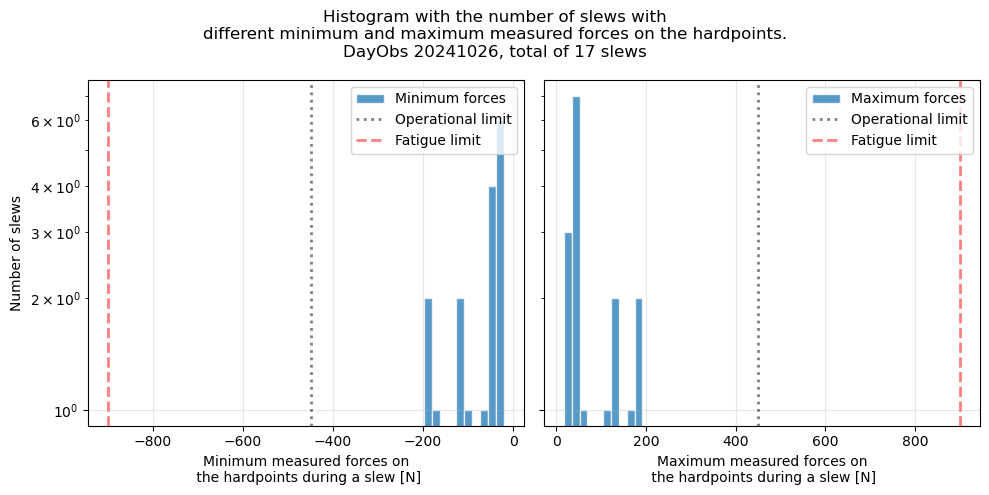

In [19]:
%matplotlib inline 
block.plot_histogram_hp_minmax_forces(df_hp_forces, day_obs)